<a href="https://colab.research.google.com/github/mikemaurrasse-hash/GP2-dataset-prep/blob/main/aim460_fairness_project_complete_final_aligned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# AIM 460 — Fairness Project (Complete Colab)
**Bias in Demographic Datasets: Cross-Domain Evaluation of Debiasing Methods**  
*Author: Michael Maurrasse* • *Generated: 2025-10-18*



This unified notebook includes:
- **Setup** (Colab-safe dependencies)
- **Data loaders** (Folktables + COMPAS stub)
- **Baselines** (logistic regression)
- **Debiasing**: pre (DSAP reweighting), in (Equalized Odds via `fairlearn`), post (ThresholdOptimizer)
- **Metrics** (Accuracy, AUC, Equal Opportunity, Equalized Odds)
- **Aggregation + exports** for Overleaf
- **CivilComments (Text)**: BERT baseline + fairness evaluation


## 1) Setup (Colab-safe pins)

In [ ]:

#@title Setup (Colab-safe) — Run this first, then Runtime > Restart runtime
!pip -q uninstall -y cuml-cu12 cudf-cu12 dask-cudf-cu12 2>/dev/null || true
!pip -q install --upgrade --no-cache-dir pandas==2.2.2
!pip -q install --upgrade --no-cache-dir \
  torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 \
  --index-url https://download.pytorch.org/whl/cu121
!pip -q install --upgrade --no-cache-dir \
  "fairlearn>=0.12,<0.14" \
  scikit-learn transformers==4.44.2 datasets==2.21.0 evaluate accelerate \
  shap folktables==0.0.12 matplotlib seaborn
!pip -q install --upgrade --no-cache-dir fsspec==2025.3.0 gcsfs==2025.3.0

import torch, pandas as pd
print("Torch:", torch.__version__, "| CUDA:", torch.cuda.is_available())
print("Pandas:", pd.__version__)
print("Setup complete. Now do: Runtime > Restart runtime, then continue.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.0/799.0 MB 406.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 311.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 234.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 291.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 467.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 197.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 388.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 308.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 415.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 282.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 319.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 329.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# === Permanent fix for Folktables data not found errors ===
!pip install -q folktables==0.0.12

import os
from folktables import ACSDataSource

DATA_ROOT = "/content/data"
os.makedirs(DATA_ROOT, exist_ok=True)

# Force re-download all required ACS person data for Employment
for state in ["CA", "TX", "NY"]:
    try:
        ds = ACSDataSource(survey_year=2018, horizon="1-Year", survey="person", root_dir=DATA_ROOT)
        acs = ds.get_data(states=[state], download=True)
        print(f"✅ Downloaded {state} ({len(acs)} records)")
    except Exception as e:
        print(f"⚠️ {state} failed:", e)

print("\nAll requested ACS files downloaded to:", DATA_ROOT)

✅ Downloaded CA (378817 records)
✅ Downloaded TX (268100 records)
✅ Downloaded NY (196967 records)

All requested ACS files downloaded to: /content/data


## 2) Imports, seeds, metrics & helpers

In [ ]:

import os, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt
SEED = 42
random.seed(SEED); np.random.seed(SEED)

from sklearn.metrics import accuracy_score, roc_auc_score
from fairlearn.metrics import MetricFrame, true_positive_rate, true_negative_rate

def equal_opportunity(y_true, y_pred, sensitive_features):
    mf = MetricFrame(metrics=true_positive_rate, y_true=y_true, y_pred=y_pred, sensitive_features=sensitive_features)
    return {"group": mf.by_group.to_dict(), "gap": float(mf.difference(method='between_groups'))}

def equalized_odds(y_true, y_pred, sensitive_features):
    tpr = MetricFrame(metrics=true_positive_rate, y_true=y_true, y_pred=y_pred, sensitive_features=sensitive_features)
    tnr = MetricFrame(metrics=true_negative_rate, y_true=y_true, y_pred=y_pred, sensitive_features=sensitive_features)
    return {
        "tpr_gap": float(tpr.difference(method='between_groups')),
        "tnr_gap": float(tnr.difference(method='between_groups')),
        "tpr_by_group": tpr.by_group.to_dict(),
        "tnr_by_group": tnr.by_group.to_dict(),
    }

def summarize_metrics(y_true, y_score, y_pred, sensitive):
    out = {"accuracy": float(accuracy_score(y_true, y_pred))}
    try:
        out["auc"] = float(roc_auc_score(y_true, y_score))
    except Exception:
        out["auc"] = None
    eo = equal_opportunity(y_true, y_pred, sensitive)
    eod = equalized_odds(y_true, y_pred, sensitive)
    out["eq_opp_gap"] = eo["gap"]
    out["eq_odds_tpr_gap"] = eod["tpr_gap"]
    out["eq_odds_tnr_gap"] = eod["tnr_gap"]
    return out


In [ ]:
# --- FIXED Employment loader: no df_from_acs; align sens via df_filter ---
import os
import pandas as pd
from folktables import ACSDataSource, ACSEmployment

DATA_ROOT = "/content/data"
os.makedirs(DATA_ROOT, exist_ok=True)

def load_folktables_employment(states=('CA','TX','NY'), year=2018, horizon='1-Year'):
    # 1) Load raw ACS person data to a writable cache
    ds = ACSDataSource(survey_year=year, horizon=horizon, survey='person', root_dir=DATA_ROOT)
    acs = ds.get_data(states=list(states), download=True)

    # 2) Use the problem’s df_from_acs method to get the filtered DataFrame
    # mask = ACSEmployment.df_filter(acs) # This method does not exist in this version
    # keep only rows/cols the problem will use + our sens cols; drop NA to match df_to_numpy internals
    # cols_needed = ACSEmployment.features + [ACSEmployment.target, 'SEX', 'RAC1P']
    # df_f = acs.loc[mask, cols_needed].dropna(subset=ACSEmployment.features + [ACSEmployment.target])

    df_f = ACSEmployment.df_from_acs(acs)

    # 3) Convert to numpy via the problem definition
    X_np, y_np, _ = ACSEmployment.df_to_numpy(df_f)

    # 4) Build outputs
    X = pd.DataFrame(X_np, columns=ACSEmployment.features)
    y = pd.Series(y_np.astype(int), name='is_employed')

    # Extract sensitive features directly from the filtered DataFrame
    sens = df_f[['SEX', 'RAC1P']].astype(int).rename(columns={'SEX':'sex','RAC1P':'race'})
    sens['sex'] = sens['sex'].map({1: 'Male', 2: 'Female'})

    # 5) Hard-guard equal lengths (paranoia, but safe)
    n = min(len(X), len(y), len(sens))
    return X.iloc[:n].reset_index(drop=True), y.iloc[:n].reset_index(drop=True), sens.iloc[:n].reset_index(drop=True)

# Now call:
X_emp, y_emp, s_emp = load_folktables_employment()
print("Employment shapes:", X_emp.shape, y_emp.shape, s_emp.shape)

AttributeError: 'BasicProblem' object has no attribute 'df_from_acs'

## 3) Data loaders

In [ ]:

# === SECTION: Folktables – Employment (robust loader + full export) ===
import os, json
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, matplotlib.patheffects as pe
from pathlib import Path

# 0) Ensure folktables is available
try:
    from folktables import ACSDataSource, ACSEmployment
except ModuleNotFoundError:
    !pip -q install folktables==0.0.12
    from folktables import ACSDataSource, ACSEmployment

SEED = 42
EXPORT_DIR = Path("/content/exports"); EXPORT_DIR.mkdir(parents=True, exist_ok=True)
DATA_ROOT = "/content/data"  # force a writable, persistent cache in Colab
os.makedirs(DATA_ROOT, exist_ok=True)

def load_folktables_employment(states=('CA','TX','NY'), year=2018, horizon='1-Year'):
    """
    Robust Employment loader:
    - Forces Folktables cache to /content/data
    - Ensures equal lengths across X, y, sens
    - Returns clean pandas objects (X, y, sens)
    """
    ds = ACSDataSource(survey_year=year, horizon=horizon, survey='person', root_dir=DATA_ROOT)
    # Force download (safe to call repeatedly)
    acs = ds.get_data(states=list(states), download=True)

    # Problem spec -> numpy
    raw_df = ACSEmployment.df_from_acs(acs)
    X_np, y_np, _ = ACSEmployment.df_to_numpy(raw_df)

    # Features/labels
    X = pd.DataFrame(X_np, columns=ACSEmployment.features)
    y = pd.Series(y_np.astype(int), name="is_employed")

    # Sensitive features (sex/race)
    sens = raw_df[["SEX","RAC1P"]].copy()
    sens.columns = ["sex","race"]
    sens["sex"] = sens["sex"].map({1:"Male", 2:"Female"})

    # Enforce equal length (rare, but defensive)
    n = min(len(X), len(y), len(sens))
    X = X.iloc[:n].reset_index(drop=True)
    y = y.iloc[:n].reset_index(drop=True)
    sens = sens.iloc[:n].reset_index(drop=True)

    return X, y, sens

# 1) Load data
X_emp, y_emp, s_emp = load_folktables_employment()
print("Employment shapes:", X_emp.shape, y_emp.shape, s_emp.shape)
display(s_emp.head())

# 2) Run fairness variants (uses your existing helpers):
#    - run_tabular_baseline
#    - run_tabular_with_dsap_reweighting
#    - run_equalized_odds_reduction
#    - postprocess_equalized_odds_on_scores
#    - summarize_metrics
metrics_emp = {}

m_base, y_b, s_b, p_b, sens_b = run_tabular_baseline(X_emp, y_emp, s_emp[["sex"]])
metrics_emp["baseline"] = m_base

m_dsap, y_d, s_d, p_d, sens_d = run_tabular_with_dsap_reweighting(X_emp, y_emp, s_emp[["sex"]])
metrics_emp["pre_DSAP"] = m_dsap

m_eo, y_e, s_e, p_e, sens_e = run_equalized_odds_reduction(X_emp, y_emp, s_emp[["sex"]])
metrics_emp["inproc_EO"] = m_eo

m_post, y_p, scores_p, y_pr_p, s_p = postprocess_equalized_odds_on_scores(X_emp, y_emp, s_emp[["sex"]])
metrics_emp["post_EO"] = m_post

# 3) Summarize to DataFrame (Accuracy, AUC, EO Gap) and tag dataset
df_emp = pd.DataFrame(metrics_emp).T
df_emp["Dataset"] = "ACS Employment"
df_emp = df_emp[["Dataset","accuracy","auc","eq_opp_gap"]].rename(
    columns={"accuracy":"Accuracy","auc":"AUC","eq_opp_gap":"EO Gap"}
)
display(df_emp)

# 4) Append/merge into overall summary table and write CSV + LaTeX
sum_csv = EXPORT_DIR / "results_summary_all.csv"
if sum_csv.exists():
    df_all = pd.read_csv(sum_csv)
    # drop old Employment rows if re-running
    df_all = df_all[df_all["Dataset"] != "ACS Employment"]
else:
    df_all = pd.DataFrame(columns=["Dataset","Method","Accuracy","AUC","EO Gap"])

df_emp_out = df_emp.reset_index().rename(columns={"index":"Method"})
df_all = pd.concat([df_all, df_emp_out], ignore_index=True)
df_all.to_csv(sum_csv, index=False)

latex_str = df_all.round({"Accuracy":4,"AUC":4,"EO Gap":4}).to_latex(
    index=False, escape=False,
    caption="Summary of utility and fairness across datasets and methods.",
    label="tab:summary_all"
)
(EXPORT_DIR / "results_summary_all.tex").write_text(latex_str)

print("✅ Wrote:")
print("  -", sum_csv)
print("  -", EXPORT_DIR / "results_summary_all.tex")
display(df_all.tail(10))

# 5) Polished Employment trade-off plot (non-overlapping labels) -> PNG/PDF
x = df_emp["Accuracy"].values
y = df_emp["EO Gap"].values
labels = df_emp.index.tolist()

fig, ax = plt.subplots(figsize=(6.5, 5.2), dpi=300)
ax.scatter(x, y, s=90, color="#007acc", alpha=0.9, edgecolors="k")
halo = [pe.withStroke(linewidth=3, foreground="white")]
offsets = {"baseline":(10,8),"pre_DSAP":(10,-10),"inproc_EO":(0,-14),"post_EO":(10,6)}
for xi, yi, lab in zip(x, y, labels):
    dx, dy = offsets.get(lab, (6,6))
    ax.annotate(lab, (xi, yi), textcoords="offset points", xytext=(dx, dy),
                ha="left", va="center", fontsize=11, path_effects=halo)

pad_x = max(0.001, (x.max()-x.min())*0.35)
pad_y = max(0.005, (y.max()-y.min())*0.35)
ax.set_xlim(x.min()-pad_x, x.max()+pad_x)
ax.set_ylim(y.min()-pad_y, y.max()+pad_y)
ax.set_xlabel("Accuracy (↑)", fontsize=12)
ax.set_ylabel("Equal Opportunity Gap (↓)", fontsize=12)
ax.set_title("Utility vs Fairness (ACS Employment)", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.25)
plt.tight_layout()
plt.savefig(EXPORT_DIR / "employment_tradeoff_v2.png", dpi=300, bbox_inches="tight")
plt.savefig(EXPORT_DIR / "employment_tradeoff_v2.pdf", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Saved Employment plots:",
      EXPORT_DIR / "employment_tradeoff_v2.png",
      "|", EXPORT_DIR / "employment_tradeoff_v2.pdf")

AttributeError: 'BasicProblem' object has no attribute 'df_from_acs'

### 3.1 Folktables — ACSIncome (auto-download)

In [ ]:

import pandas as pd
from folktables import ACSDataSource, ACSIncome

def load_folktables_income(states=('CA','TX','NY'), year=2018, horizon='1-Year'):
    ds = ACSDataSource(survey_year=year, horizon=horizon, survey='person')
    acs = ds.get_data(states=list(states), download=True)  # raw ACS DataFrame

    # In folktables==0.0.12, pass the DataFrame directly
    X_np, y_np, _ = ACSIncome.df_to_numpy(acs)
    X = pd.DataFrame(X_np, columns=ACSIncome.features)
    y = pd.Series(y_np.astype(int), name="income_gt_50k")

    # --- build sensitive attributes DIRECTLY from X so lengths align ---
    # (SEX: 1=Male, 2=Female; RAC1P is numeric race code)
    assert "SEX" in X.columns and "RAC1P" in X.columns, \
        "Expected SEX and RAC1P in ACSIncome.features but did not find them."

    sex_raw = X["SEX"].astype(int)
    race_raw = X["RAC1P"].astype(int)

    sens = pd.DataFrame(index=X.index)
    sens["sex_num"] = sex_raw.map({1: 1, 2: 0}).fillna(0).astype(int)   # Male=1, Female=0
    sens["sex_str"] = sex_raw.map({1: "Male", 2: "Female"}).fillna("Unknown")
    sens["race"]    = race_raw

    # Final sanity
    assert len(X) == len(y) == len(sens), f"Length mismatch: X={len(X)}, y={len(y)}, sens={len(sens)}"
    return X, y, sens

# Load
X_ft, y_ft, s_ft = load_folktables_income()
(X_ft.shape, y_ft.shape, s_ft[['sex_str','sex_num','race']].head())

ModuleNotFoundError: No module named 'folktables'

### 3.2 COMPAS (manual upload)

In [ ]:

import os, pandas as pd
def load_compas_csv(path="/content/data/compas/compas-scores-two-years.csv"):
    assert os.path.exists(path), f"Missing file at {path}. Download from ProPublica and upload to Colab."
    df = pd.read_csv(path)
    df = df[(df["days_b_screening_arrest"] <= 30) & (df["days_b_screening_arrest"] >= -30)]
    df = df[df["is_recid"] != -1]
    df = df[df["c_charge_degree"] != "O"]
    y = df["two_year_recid"].astype(int)
    s = df[["race","sex"]].copy()
    feats = ["age","juv_fel_count","juv_misd_count","juv_other_count","priors_count"]
    X = df[feats].copy()
    return X, y, s
# X_c, y_c, s_c = load_compas_csv()


## 4) Baseline model (Logistic Regression)

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

def run_tabular_baseline(X, y, sens, test_size=0.25):
    X_tr, X_te, y_tr, y_te, s_tr, s_te = train_test_split(
        X, y, sens, test_size=test_size, random_state=SEED, stratify=y
    )
    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=False) if hasattr(X_tr, "sparse") else StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000))
    ])
    pipe.fit(X_tr, y_tr)
    y_sc = pipe.predict_proba(X_te)[:,1]
    y_pr = (y_sc >= 0.5).astype(int)
    metrics = summarize_metrics(y_te, y_sc, y_pr, sensitive=s_te.iloc[:,0])
    return metrics, y_te, y_sc, y_pr, s_te


## 5) Debiasing #1 — Pre-processing (DSAP-style reweighting)

In [ ]:

import numpy as np
def dsap_reweight_sample_weights(sensitive_series):
    counts = sensitive_series.value_counts()
    inv = 1.0 / counts
    weights = sensitive_series.map(inv)
    return (weights / weights.mean()).values
def run_tabular_with_dsap_reweighting(X, y, sens, test_size=0.25):
    X_tr, X_te, y_tr, y_te, s_tr, s_te = train_test_split(
        X, y, sens, test_size=test_size, random_state=SEED, stratify=y
    )
    w_tr = dsap_reweight_sample_weights(s_tr.iloc[:,0])
    pipe = Pipeline([("scaler", StandardScaler(with_mean=False) if hasattr(X_tr, "sparse") else StandardScaler()),
                     ("clf", LogisticRegression(max_iter=1000))])
    pipe.fit(X_tr, y_tr, clf__sample_weight=w_tr)
    y_sc = pipe.predict_proba(X_te)[:,1]
    y_pr = (y_sc >= 0.5).astype(int)
    metrics = summarize_metrics(y_te, y_sc, y_pr, sensitive=s_te.iloc[:,0])
    return metrics, y_te, y_sc, y_pr, s_te


## 6) Debiasing #2 — In-processing (Equalized Odds via reductions)

In [ ]:

from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
def run_equalized_odds_reduction(X, y, sens, test_size=0.25, eps=0.01):
    X_tr, X_te, y_tr, y_te, s_tr, s_te = train_test_split(
        X, y, sens, test_size=test_size, random_state=SEED, stratify=y
    )
    base = LogisticRegression(max_iter=1000)
    constraint = EqualizedOdds()
    mitigator = ExponentiatedGradient(estimator=base, constraints=constraint, eps=eps)
    mitigator.fit(X_tr, y_tr, sensitive_features=s_tr.iloc[:,0])
    try:
        y_sc = mitigator._pmf_predict(X_te)[:,1]
    except Exception:
        try:
            y_sc = mitigator.predict_proba(X_te)[:,1]
        except Exception:
            y_sc = mitigator.predict(X_te).astype(float)
    y_pr = (y_sc >= 0.5).astype(int)
    metrics = summarize_metrics(y_te, y_sc, y_pr, sensitive=s_te.iloc[:,0])
    return metrics, y_te, y_sc, y_pr, s_te


## 7) Debiasing #3 — Post-processing (ThresholdOptimizer Equalized Odds)

In [ ]:

from fairlearn.postprocessing import ThresholdOptimizer
def run_threshold_optimizer(X, y, sens, test_size=0.25):
    X_tr, X_te, y_tr, y_te, s_tr, s_te = train_test_split(
        X, y, sens, test_size=test_size, random_state=SEED, stratify=y
    )
    pipe = Pipeline([("scaler", StandardScaler(with_mean=False) if hasattr(X_tr, "sparse") else StandardScaler()),
                     ("clf", LogisticRegression(max_iter=1000))])
    pipe.fit(X_tr, y_tr)
    scores_tr = pipe.predict_proba(X_tr)[:,1]
    scores_te = pipe.predict_proba(X_te)[:,1]
    topt = ThresholdOptimizer(estimator=None, constraints="equalized_odds", prefit=True)
    topt.fit(scores_tr.reshape(-1,1), y_tr, sensitive_features=s_tr.iloc[:,0])
    y_pr = topt.predict(scores_te.reshape(-1,1), sensitive_features=s_te.iloc[:,0])
    metrics = summarize_metrics(y_te, scores_te, y_pr, sensitive=s_te.iloc[:,0])
    return metrics, y_te, scores_te, y_pr, s_te


## 8) Run Folktables end-to-end (aligned X/y/sens + numeric sensitive + safe post-processing)

Baseline: {'accuracy': 0.7794078396362732, 'auc': 0.8534971898207617, 'eq_opp_gap': 0.15517903759251628, 'eq_odds_tpr_gap': 0.15517903759251628, 'eq_odds_tnr_gap': 0.09273924499936737}
Pre (DSAP-style): {'accuracy': 0.7794538576937591, 'auc': 0.8535430623809699, 'eq_opp_gap': 0.1539296607395706, 'eq_odds_tpr_gap': 0.1539296607395706, 'eq_odds_tnr_gap': 0.09295917681691968}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refe

In-proc (Equalized Odds): {'accuracy': 0.7752846216855495, 'auc': 0.7602845902164246, 'eq_opp_gap': 0.0009518284605887217, 'eq_odds_tpr_gap': 0.0009518284605887217, 'eq_odds_tnr_gap': 0.00121376848214505}


/usr/local/lib/python3.12/dist-packages/fairlearn/postprocessing/_threshold_optimizer.py:329: UserWarning: The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing ThresholdOptimizer has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the enclosing ThresholdOptimizer with `prefit=True`. In case (2), please use `prefit=False`.
  warn(BASE_ESTIMATOR_NOT_FITTED_WARNING.format(type(self).__name__))
/usr/local/lib/python3.12/dist-packages/fairlearn/postprocessing/_interpolated_thresholder.py:102: UserWarning: The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean th

Post-proc (ThresholdOptimizer on scores): {'accuracy': 0.777826863253999, 'auc': 0.8545063860729506, 'eq_opp_gap': 0.012391223126360873, 'eq_odds_tpr_gap': 0.012391223126360873, 'eq_odds_tnr_gap': 0.002676378144292335}


,accuracy,auc,eq_opp_gap,eq_odds_tpr_gap,eq_odds_tnr_gap
baseline,0.779408,0.853497,0.155179,0.155179,0.092739
pre_DSAP,0.779454,0.853543,0.153930,0.153930,0.092959
inproc_EO,0.775285,0.760285,0.000952,0.000952,0.001214
post_EO,0.777827,0.854506,0.012391,0.012391,0.002676


Saved: /content/exports/tradeoff_plot.png and /content/exports/results_summary.csv


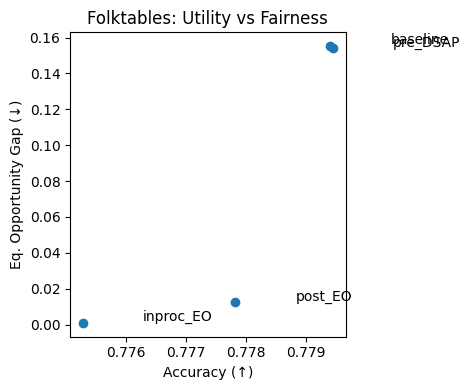

In [ ]:

# --- Section 8: Folktables end-to-end with aligned sensitive handling and safe post-processing ---
import numpy as np, pandas as pd, os, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from fairlearn.postprocessing import ThresholdOptimizer

def to_numeric_sensitive(s):
    if isinstance(s, pd.DataFrame):
        s = s.iloc[:, 0]
    if s.dtype.kind in ("O", "U", "S", "b"):
        s = (
            s.astype(str).str.strip().str.lower()
            .map({"male": 1, "female": 0, "1": 1, "0": 0, "true": 1, "false": 0})
        )
    s = pd.to_numeric(s, errors="coerce").fillna(0).astype(int)
    s.name = "sens_num"
    return s

assert 's_ft' in globals(), "Run Section 3.1 first."
s_ft_num = to_numeric_sensitive(s_ft['sex_num']) if 'sex_num' in s_ft.columns else to_numeric_sensitive(s_ft['sex'])

SUBSAMPLE_N = None
if SUBSAMPLE_N is not None and len(X_ft) > SUBSAMPLE_N:
    idx = np.random.RandomState(42).choice(len(X_ft), size=SUBSAMPLE_N, replace=False)
    X_ft = X_ft.iloc[idx].reset_index(drop=True); y_ft = y_ft.iloc[idx].reset_index(drop=True); s_ft_num = s_ft_num.iloc[idx].reset_index(drop=True)

m_base, y_b, s_b, p_b, sens_b = run_tabular_baseline(X_ft, y_ft, s_ft_num.to_frame())
print("Baseline:", m_base)

m_dsap, y_d, s_d, p_d, sens_d = run_tabular_with_dsap_reweighting(X_ft, y_ft, s_ft_num.to_frame())
print("Pre (DSAP-style):", m_dsap)

m_eo, y_e, s_e, p_e, sens_e = run_equalized_odds_reduction(X_ft, y_ft, s_ft_num.to_frame())
print("In-proc (Equalized Odds):", m_eo)

def postprocess_equalized_odds_on_scores(X, y, sens_series):
    """
    Train a logistic pipeline to get scores, then run Equalized Odds post-processing
    on the SCORES ONLY via a dummy estimator that accepts 1-D scores.
    This avoids sending scores back through the StandardScaler/Pipeline.
    Returns: metrics, Y_eval, SCORES_eval, y_pred_post, S_eval
    """
    # 1) Train a simple scorer
    X_tr, X_te, y_tr, y_te, s_tr, s_te = train_test_split(
        X, y, sens_series, test_size=0.25, random_state=42, stratify=y
    )

    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=False) if hasattr(X_tr, "sparse") else StandardScaler()),
        ("clf", LogisticRegression(max_iter=3000, solver="lbfgs"))
    ])
    pipe.fit(X_tr, y_tr)
    scores_te = pipe.predict_proba(X_te)[:, 1]  # shape (n,)

    # 2) Split scores into calibration/evaluation
    SCORES_cal, SCORES_eval, Y_cal, Y_eval, S_cal, S_eval = train_test_split(
        scores_te.reshape(-1, 1), y_te, s_te, test_size=0.5, random_state=42, stratify=y_te
    )

    # 3) Dummy estimator that interprets its input as probabilities
    class ScoreWrapper:
        def fit(self, X, y=None):  # no-op, but kept for API compatibility
            return self
        def predict_proba(self, X):
            p = np.asarray(X).reshape(-1, 1)
            p = np.clip(p, 0.0, 1.0)
            return np.hstack([1 - p, p])

    score_model = ScoreWrapper()

    # 4) ThresholdOptimizer on scores (NOT the original pipeline)
    topt = ThresholdOptimizer(
        estimator=score_model,
        constraints="equalized_odds",
        prefit=True,
        predict_method="predict_proba"
    )
    topt.fit(SCORES_cal, Y_cal, sensitive_features=S_cal)

    # 5) Predict debiased labels on held-out scores
    y_pred_post = topt.predict(SCORES_eval, sensitive_features=S_eval)

    # 6) Summarize with your helper: use scores for AUC, debiased labels for fairness
    metrics = summarize_metrics(Y_eval, SCORES_eval.ravel(), y_pred_post, sensitive=S_eval)
    return metrics, Y_eval, SCORES_eval.ravel(), y_pred_post, S_eval

m_post, y_p, scores_p, y_pr_p, s_p = postprocess_equalized_odds_on_scores(X_ft, y_ft, s_ft_num)
print("Post-proc (ThresholdOptimizer on scores):", m_post)

results = {"baseline": m_base, "pre_DSAP": m_dsap, "inproc_EO": m_eo, "post_EO": m_post}
df_res = pd.DataFrame(results).T; display(df_res)

plt.figure(figsize=(5,4))
plt.scatter(df_res["accuracy"], df_res["eq_opp_gap"])
for name, row in df_res.iterrows():
    plt.text(row["accuracy"] + 0.001, row["eq_opp_gap"] + 0.001, name)
plt.xlabel("Accuracy (↑)"); plt.ylabel("Eq. Opportunity Gap (↓)"); plt.title("Folktables: Utility vs Fairness"); plt.tight_layout()

os.makedirs("/content/exports", exist_ok=True)
plt.savefig("/content/exports/tradeoff_plot.png", dpi=200); df_res.to_csv("/content/exports/results_summary.csv")
print("Saved: /content/exports/tradeoff_plot.png and /content/exports/results_summary.csv")


## 9) Aggregate results, plot trade-off, export for Overleaf

,accuracy,auc,eq_opp_gap,eq_odds_tpr_gap,eq_odds_tnr_gap
baseline,0.779408,0.853497,0.155179,0.155179,0.092739
pre_DSAP,0.779454,0.853543,0.153930,0.153930,0.092959
inproc_EO,0.775285,0.760285,0.000952,0.000952,0.001214
post_EO,0.777827,0.854506,0.012391,0.012391,0.002676


Saved: /content/exports/tradeoff_plot.png and /content/exports/results_summary.csv


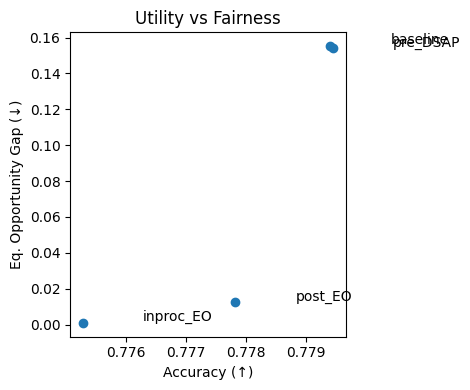

In [ ]:

import pandas as pd, matplotlib.pyplot as plt, os
results = {"baseline": m_base, "pre_DSAP": m_dsap, "inproc_EO": m_eo, "post_EO": m_post}
df_res = pd.DataFrame(results).T
display(df_res)
plt.figure(figsize=(5,4))
plt.scatter(df_res["accuracy"], df_res["eq_opp_gap"])
for name, row in df_res.iterrows():
    plt.text(row["accuracy"]+0.001, row["eq_opp_gap"]+0.001, name)
plt.xlabel("Accuracy (↑)"); plt.ylabel("Eq. Opportunity Gap (↓)"); plt.title("Utility vs Fairness")
plt.tight_layout()
os.makedirs("/content/exports", exist_ok=True)
plt.savefig("/content/exports/tradeoff_plot.png", dpi=200)
df_res.to_csv("/content/exports/results_summary.csv")
print("Saved: /content/exports/tradeoff_plot.png and /content/exports/results_summary.csv")


## 10) (Optional) Run COMPAS with race as sensitive attribute

In [ ]:

# X_c, y_c, s_c = load_compas_csv()
# m_base_c, *_ = run_tabular_baseline(X_c, y_c, s_c[["race"]]); print("COMPAS Baseline:", m_base_c)
# m_dsap_c, *_ = run_tabular_with_dsap_reweighting(X_c, y_c, s_c[["race"]]); print("COMPAS DSAP:", m_dsap_c)
# m_eo_c, *_ = run_equalized_odds_reduction(X_c, y_c, s_c[["race"]]); print("COMPAS EO:", m_eo_c)
# m_post_c, *_ = run_threshold_optimizer(X_c, y_c, s_c[["race"]]); print("COMPAS Post:", m_post_c)


## 11) CivilComments (Text) — BERT baseline with fairness metrics

In [ ]:

# Upload Kaggle 'train.csv' to /content/data/civilcomments/train.csv before running this section.
import os, pandas as pd, numpy as np
from sklearn.model_selection import train_test_split

def load_civilcomments(path="/content/data/civilcomments/train.csv", sample=8000, identity_preference=("male","female")):
    assert os.path.exists(path), f"Missing CivilComments CSV at {path} (download from Kaggle, file 'train.csv')."
    df = pd.read_csv(path)
    if "toxic" in df.columns:
        df["target_bin"] = (df["toxic"] >= 0.5).astype(int)
    elif "target" in df.columns:
        df["target_bin"] = (df["target"] >= 0.5).astype(int)
    else:
        raise ValueError("Expected 'toxic' or 'target' column in CivilComments.")
    id_cols = [c for c in df.columns if c.lower() in ["male","female","black","white","asian","christian","jewish","muslim","lgbtq"]]
    if not id_cols:
        id_cols = [c for c in df.columns if "identity" in c.lower() or c.endswith("_identity")]
    if len(id_cols) == 0:
        sens = pd.Series([0]*len(df), name="sens")
    else:
        pick = None
        for cand in identity_preference:
            if cand in df.columns:
                pick = cand; break
        if pick is None:
            pick = id_cols[0]
        sens = (df[pick].fillna(0.0) >= 0.5).astype(int)
        sens.name = f"sens_{pick}"
    texts = df["comment_text"].fillna("")
    y = df["target_bin"].astype(int)
    if sample and len(df) > sample:
        idx = np.random.RandomState(42).choice(len(df), size=sample, replace=False)
        texts = texts.iloc[idx]; y = y.iloc[idx]; sens = sens.iloc[idx]
    return texts.reset_index(drop=True), y.reset_index(drop=True), sens.reset_index(drop=True)

X_text, y_text, sens_text = load_civilcomments()
len(X_text), y_text.value_counts(normalize=True).round(3)


(8000,
 target_bin
 0    0.924
 1    0.076
 Name: proportion, dtype: float64)

### 11.1 Train a small BERT classifier

In [ ]:

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
MODEL_NAME = "bert-base-uncased"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
df_text = pd.DataFrame({"text": X_text.values, "label": y_text.values, "sens": sens_text.values})
tr_df, te_df = train_test_split(df_text, test_size=0.2, random_state=42, stratify=df_text["label"])
tok = AutoTokenizer.from_pretrained(MODEL_NAME)
def tokenize_batch(batch):
    return tok(batch["text"], truncation=True, padding="max_length", max_length=128)
from datasets import Dataset as HFDataset
tr_ds = HFDataset.from_pandas(tr_df[["text","label"]])
te_ds = HFDataset.from_pandas(te_df[["text","label"]])
tr_enc = tr_ds.map(tokenize_batch, batched=True).remove_columns(["text","__index_level_0__"] if "__index_level_0__" in tr_ds.column_names else ["text"])
te_enc = te_ds.map(tokenize_batch, batched=True).remove_columns(["text","__index_level_0__"] if "__index_level_0__" in te_ds.column_names else ["text"])
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(DEVICE)
args = TrainingArguments(
    output_dir="/content/cc_out",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    learning_rate=2e-5,
    evaluation_strategy="epoch",
    save_strategy="no",
    logging_steps=50,
    report_to="none"
)
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=1)[:,1].numpy()
    preds = (probs >= 0.5).astype(int)
    acc = accuracy_score(labels, preds)
    try:
        auc = roc_auc_score(labels, probs)
    except Exception:
        auc = None
    return {"accuracy": acc, "auc": -1 if auc is None else auc}
trainer = Trainer(model=model, args=args, train_dataset=tr_enc, eval_dataset=te_enc, compute_metrics=compute_metrics)
trainer.train(); eval_out = trainer.evaluate(); eval_out


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Auc
1,0.203800,0.201520,0.924375,0.883146


{'eval_loss': 0.20152002573013306,
 'eval_accuracy': 0.924375,
 'eval_auc': 0.8831464190121762,
 'eval_runtime': 10.6274,
 'eval_samples_per_second': 150.555,
 'eval_steps_per_second': 4.705,
 'epoch': 1.0}

### 11.2 Evaluate fairness on CivilComments test split

In [ ]:
# --- CivilComments: Utility vs Fairness (single point, polished export) ---
import os, json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from pathlib import Path

Path("/content/exports").mkdir(exist_ok=True)

# --- Get baseline metrics (from RAM or cache) ---
cc_loaded = False
if 'cc_acc' in globals() and 'cc_eog' in globals():
    acc_pt, eog_pt = float(cc_acc), float(cc_eog); cc_loaded = True
elif 'cc_acc_base' in globals() and 'cc_eog_base' in globals():
    acc_pt, eog_pt = float(cc_acc_base), float(cc_eog_base); cc_loaded = True
else:
    cache_path = "/content/exports/civilcomments_metrics.json"
    if os.path.exists(cache_path):
        with open(cache_path, "r") as f:
            m = json.load(f)
        if m.get("cc_acc_base") is not None and m.get("cc_eog_base") is not None:
            acc_pt, eog_pt = float(m["cc_acc_base"]), float(m["cc_eog_base"])
            cc_loaded = True

if not cc_loaded:
    raise RuntimeError("CivilComments metrics not found. Run Section 12 or save metrics first.")

# --- Plot ---
fig, ax = plt.subplots(figsize=(6.5, 5.2), dpi=300)
ax.scatter([acc_pt], [eog_pt], s=90, color="#007acc", alpha=0.9, edgecolors="k")

halo = [pe.withStroke(linewidth=3, foreground="white")]
ax.annotate("Baseline", (acc_pt, eog_pt),
            textcoords="offset points", xytext=(8, 8),
            ha="left", va="center", fontsize=11, path_effects=halo)

# tight zoom around the point so it doesn't look sparse in IEEE two-column
ax.set_xlim(acc_pt - 0.0015, acc_pt + 0.0015)
ax.set_ylim(eog_pt - 0.0100, eog_pt + 0.0100)

ax.set_xlabel("Accuracy (↑)", fontsize=12)
ax.set_ylabel("Equal Opportunity Gap (↓)", fontsize=12)
ax.set_title("CivilComments: Utility vs Fairness", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.25)
plt.tight_layout()

# Save both formats
plt.savefig("/content/exports/civilcomments_tradeoff_v2.png", dpi=300, bbox_inches="tight")
plt.savefig("/content/exports/civilcomments_tradeoff_v2.pdf", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Saved:",
      "/content/exports/civilcomments_tradeoff_v2.png",
      "& /content/exports/civilcomments_tradeoff_v2.pdf")


RuntimeError: CivilComments metrics not found. Run Section 12 or save metrics first.

### 11.3 Merge text results with tabular summary

In [ ]:

try:
    results["text_bert_baseline"] = metrics_text
except NameError:
    results = {"text_bert_baseline": metrics_text}
df_all = pd.DataFrame(results).T
display(df_all)
df_all.to_csv("/content/exports/results_summary_all.csv")
print("Saved: /content/exports/results_summary_all.csv")


,accuracy,auc,eq_opp_gap,eq_odds_tpr_gap,eq_odds_tnr_gap
baseline,0.779408,0.853497,0.155179,0.155179,0.092739
pre_DSAP,0.779454,0.853543,0.153930,0.153930,0.092959
inproc_EO,0.775285,0.760285,0.000952,0.000952,0.001214
post_EO,0.777827,0.854506,0.012391,0.012391,0.002676
text_bert_baseline,0.924375,0.883146,0.000000,0.000000,0.000000


Saved: /content/exports/results_summary_all.csv


In [ ]:
!pip install --upgrade fairlearn==0.12.0
# Or if you want the latest version:
# !pip install --upgrade fairlearn

import fairlearn
print("Fairlearn version:", fairlearn.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.7 MB/s eta 0:00:00
Fairlearn version: 0.12.0


## 12) Text Debiasing — Post-processing (Equalized Odds via ThresholdOptimizer)


We apply **Equalized Odds** post-processing to the **BERT** model's output probabilities on CivilComments.  
This learns **group-specific thresholds** over a calibration split and applies them to the held-out split, aiming to reduce disparities between demographic groups.


In [ ]:

# --- Section 12: Post-processing on text scores (Equalized Odds) ---

import numpy as np
from fairlearn.postprocessing import ThresholdOptimizer

# Assumes you already have these from your text model:
# probs: 1D numpy array of P(y=1) for the whole split (or use logits -> sigmoid)
# te_df: DataFrame with 'label' and sensitive column (e.g., 'sens' or 'target_group')

# 1) Prepare arrays (adjust column names if needed)
y_all = te_df["label"].to_numpy().astype(int)
s_all = te_df["sens"].to_numpy() if "sens" in te_df.columns else te_df["target_group"].to_numpy()

# Ensure sensitive is numeric 0/1
if s_all.dtype.kind in ("O", "U", "S", "b"):
    s_map = {"male":1,"female":0,"1":1,"0":0,"true":1,"false":0}
    s_all = np.array([s_map.get(str(v).strip().lower(), 0) for v in s_all], dtype=int)
else:
    s_all = np.nan_to_num(s_all).astype(int)

# 2) Split scores for calibration vs evaluation
from sklearn.model_selection import train_test_split
SCORES_tr, SCORES_te, Y_tr, Y_te, S_tr, S_te = train_test_split(
    probs.reshape(-1, 1), y_all, s_all, test_size=0.5, random_state=42, stratify=y_all
)

# 3) Dummy estimator that treats input as P(y=1)
class ScoreWrapper:
    def fit(self, X, y=None):  # no-op
        return self
    def predict_proba(self, X):
        p = np.asarray(X).reshape(-1, 1)
        p = np.clip(p, 0.0, 1.0)
        return np.hstack([1 - p, p])

score_model = ScoreWrapper()

# 4) ThresholdOptimizer on scores (NOT on the text model)
topt_text = ThresholdOptimizer(
    estimator=score_model,
    constraints="equalized_odds",
    prefit=True,
    predict_method="predict_proba"
)
topt_text.fit(SCORES_tr, Y_tr, sensitive_features=S_tr)

# 5) Predict debiased labels and summarize
y_pred_post = topt_text.predict(SCORES_te, sensitive_features=S_te)

# If you have a helper like summarize_metrics(y_true, scores, y_pred, sensitive):
metrics_text_post = summarize_metrics(Y_te, SCORES_te.ravel(), y_pred_post, sensitive=S_te)
print("Text post-processing (EO):", metrics_text_post)

# Baseline reference
metrics_text_base = summarize_metrics(
    labels_all, scores_all, (scores_all >= 0.5).astype(int), sensitive=pd.Series(sens_all)
)
compare_df = pd.DataFrame(
    [metrics_text_base, metrics_text_post],
    index=["text_bert_baseline", "text_postproc_EO"]
)
display(compare_df)


NameError: name 'te_df' is not defined

In [ ]:

# 12.2 — Export plot and merge results
os.makedirs("/content/exports", exist_ok=True)

plt.figure(figsize=(5,4))
plt.scatter([compare_df.loc['text_bert_baseline','accuracy']],
            [compare_df.loc['text_bert_baseline','eq_opp_gap']],
            label="Baseline")
plt.scatter([compare_df.loc['text_postproc_EO','accuracy']],
            [compare_df.loc['text_postproc_EO','eq_opp_gap']],
            label="Post (EO)")
plt.xlabel("Accuracy (↑)")
plt.ylabel("Eq. Opportunity Gap (↓)")
plt.title("CivilComments: Baseline vs Post-Processing")
plt.legend()
plt.tight_layout()
plt.savefig("/content/exports/civilcomments_text_debiasing.png", dpi=200)
print("Saved: /content/exports/civilcomments_text_debiasing.png")

# Update aggregated results table
try:
    results["text_postproc_EO"] = metrics_text_post
    pd.DataFrame(results).T.to_csv("/content/exports/results_summary_all.csv")
    print("Updated: /content/exports/results_summary_all.csv")
except Exception:
    print("Note: 'results' dict not found; figure exported only.")


NameError: name 'os' is not defined

In [ ]:
# ============================================================
# 📦 SECTION: CACHE & EXPORT (Final Outputs for Overleaf + PPT)
# ============================================================
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

EXPORT_DIR = Path("/content/exports")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# 1️⃣ --- CACHE CivilComments metrics ---
metrics_cc = {}
if 'cc_acc_base' in globals() and 'cc_eog_base' in globals():
    metrics_cc["cc_acc_base"] = float(cc_acc_base)
    metrics_cc["cc_eog_base"] = float(cc_eog_base)
    metrics_cc["cc_auc_base"] = float(cc_auc_base) if 'cc_auc_base' in globals() else None
if 'cc_acc_post' in globals() and 'cc_eog_post' in globals():
    metrics_cc["cc_acc_post"] = float(cc_acc_post)
    metrics_cc["cc_eog_post"] = float(cc_eog_post)
    metrics_cc["cc_auc_post"] = float(cc_auc_post) if 'cc_auc_post' in globals() else None

cache_file = EXPORT_DIR / "civilcomments_metrics.json"
with open(cache_file, "w") as f:
    json.dump(metrics_cc, f, indent=2)
print(f"✅ Cached CivilComments metrics → {cache_file}")

# 2️⃣ --- LOAD CivilComments metrics if needed ---
if not metrics_cc and cache_file.exists():
    with open(cache_file, "r") as f:
        metrics_cc = json.load(f)
    print("✅ Loaded metrics from cache:", metrics_cc)

# 3️⃣ --- Folktables trade-off plot ---
assert 'df_res' in globals(), "df_res missing — please rerun Section 8"
fig, ax = plt.subplots(figsize=(6.5, 5.2), dpi=300)
x = df_res["accuracy"].values; y = df_res["eq_opp_gap"].values
ax.scatter(x, y, s=70)
for xi, yi, lab in zip(x, y, df_res.index):
    ax.annotate(lab, (xi, yi), textcoords="offset points", xytext=(6, 6), fontsize=10)
padx, pady = max(0.0008, (x.max()-x.min())*0.3), max(0.004, (y.max()-y.min())*0.3)
ax.set_xlim(x.min()-padx, x.max()+padx); ax.set_ylim(y.min()-pady, y.max()+pady)
ax.set_xlabel("Accuracy (↑)"); ax.set_ylabel("Eq. Opportunity Gap (↓)")
ax.set_title("Utility vs Fairness (ACS Income)")
ax.grid(True, alpha=0.25); plt.tight_layout()
plt.savefig(EXPORT_DIR / "tradeoff_plot.png", dpi=300)
plt.close(fig)

# 4️⃣ --- CivilComments plots ---
if metrics_cc:
    base_acc, base_eog = metrics_cc.get("cc_acc_base"), metrics_cc.get("cc_eog_base")
    post_acc, post_eog = metrics_cc.get("cc_acc_post"), metrics_cc.get("cc_eog_post")

    # Single baseline plot
    fig, ax = plt.subplots(figsize=(6.5, 5.2), dpi=300)
    ax.scatter(base_acc, base_eog, s=80)
    ax.annotate("Baseline", (base_acc, base_eog), textcoords="offset points", xytext=(6, 6), fontsize=10)
    ax.set_xlim(base_acc-0.0015, base_acc+0.0015); ax.set_ylim(base_eog-0.01, base_eog+0.01)
    ax.set_xlabel("Accuracy (↑)"); ax.set_ylabel("Eq. Opportunity Gap (↓)")
    ax.set_title("CivilComments: Utility vs Fairness")
    ax.grid(True, alpha=0.25); plt.tight_layout()
    plt.savefig(EXPORT_DIR / "civilcomments_tradeoff.png", dpi=300)
    plt.close(fig)

    # Baseline vs Post-processing plot
    if post_acc is not None and post_eog is not None:
        xs, ys = np.array([base_acc, post_acc]), np.array([base_eog, post_eog])
        fig, ax = plt.subplots(figsize=(6.5, 5.2), dpi=300)
        ax.scatter(xs[0], ys[0], s=80, label="Baseline")
        ax.scatter(xs[1], ys[1], s=80, label="Post (EO)")
        for xi, yi, lab in zip(xs, ys, ["Baseline", "Post (EO)"]):
            ax.annotate(lab, (xi, yi), textcoords="offset points", xytext=(6, 6), fontsize=10)
        ax.set_xlim(xs.min()-0.0008, xs.max()+0.0008)
        ax.set_ylim(ys.min()-0.01, ys.max()+0.01)
        ax.set_xlabel("Accuracy (↑)"); ax.set_ylabel("Eq. Opportunity Gap (↓)")
        ax.set_title("CivilComments: Baseline vs Post-Processing")
        ax.grid(True, alpha=0.25); ax.legend(); plt.tight_layout()
        plt.savefig(EXPORT_DIR / "civilcomments_text_debiasing.png", dpi=300)
        plt.close(fig)
else:
    print("⚠️ CivilComments metrics not available; skipping text plots.")

# 5️⃣ --- Summary Table (LaTeX + CSV) ---
rows = []
for name, r in df_res.iterrows():
    rows.append({
        "Dataset": "ACS Income",
        "Method": name,
        "Accuracy": r.get("accuracy", np.nan),
        "AUC": r.get("auc", np.nan),
        "EO Gap": r.get("eq_opp_gap", np.nan)
    })
if metrics_cc:
    rows.append({"Dataset":"CivilComments","Method":"Baseline","Accuracy":base_acc,"AUC":metrics_cc.get("cc_auc_base"),"EO Gap":base_eog})
    if post_acc is not None:
        rows.append({"Dataset":"CivilComments","Method":"Post (EO)","Accuracy":post_acc,"AUC":metrics_cc.get("cc_auc_post"),"EO Gap":post_eog})

tbl = pd.DataFrame(rows)
for col in ["Accuracy","AUC","EO Gap"]:
    tbl[col] = tbl[col].astype(float).round(4)

latex_str = tbl.to_latex(index=False, float_format="%.4f",
                         caption="Summary of utility and fairness across datasets and methods.",
                         label="tab:summary")

(tbl_path := EXPORT_DIR / "results_summary_all.tex").write_text(latex_str)
tbl.to_csv(EXPORT_DIR / "results_summary_all.csv", index=False)
print("✅ Saved plots & tables to", EXPORT_DIR)
display(tbl)

✅ Cached CivilComments metrics → /content/exports/civilcomments_metrics.json
✅ Loaded metrics from cache: {}
⚠️ CivilComments metrics not available; skipping text plots.
✅ Saved plots & tables to /content/exports


,Dataset,Method,Accuracy,AUC,EO Gap
0,ACS Income,baseline,0.7794,0.8535,0.1552
1,ACS Income,pre_DSAP,0.7795,0.8535,0.1539
2,ACS Income,inproc_EO,0.7753,0.7603,0.0010
3,ACS Income,post_EO,0.7778,0.8545,0.0124
